In [1]:
import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

In [2]:
df1 = pd.read_csv('https://raw.githubusercontent.com/MandyYang86/Ride-Optimization/master/Merge%20Data/uber_pool_March.csv')
df2 = pd.read_csv('https://raw.githubusercontent.com/MandyYang86/Ride-Optimization/master/Merge%20Data/lyft_line_March.csv')
df1.head()

,date_time,date,day,uber_distance,uber_duration,uber_estimate,uber_high_estimate,uber_low_estimate,main_temp,time,weather,uber_price_per_second
0,2018-03-01 00:00:03,1-Mar-18,Thursday,1.73,360,7.5,9.0,6.0,46.69,0:00:03,Rain,0.020833
1,2018-03-01 00:01:03,1-Mar-18,Thursday,1.90,480,5.5,7.0,4.0,46.69,0:01:03,Rain,0.011458
2,2018-03-01 00:02:03,1-Mar-18,Thursday,2.26,420,7.0,9.0,5.0,46.56,0:02:03,Rain,0.016667
3,2018-03-01 00:03:02,1-Mar-18,Thursday,1.63,360,7.5,9.0,6.0,46.56,0:03:02,Rain,0.020833
4,2018-03-01 00:04:02,1-Mar-18,Thursday,2.17,480,9.5,11.0,8.0,46.56,0:04:02,Rain,0.019792


In [4]:
df1.columns

Index(['date_time', 'date', 'day', 'uber_distance', 'uber_duration',
       'uber_estimate', 'uber_high_estimate', 'uber_low_estimate', 'main_temp',
       'time', 'weather', 'uber_price_per_second'],
      dtype='object')

In [9]:
df1.shape

(44434, 12)

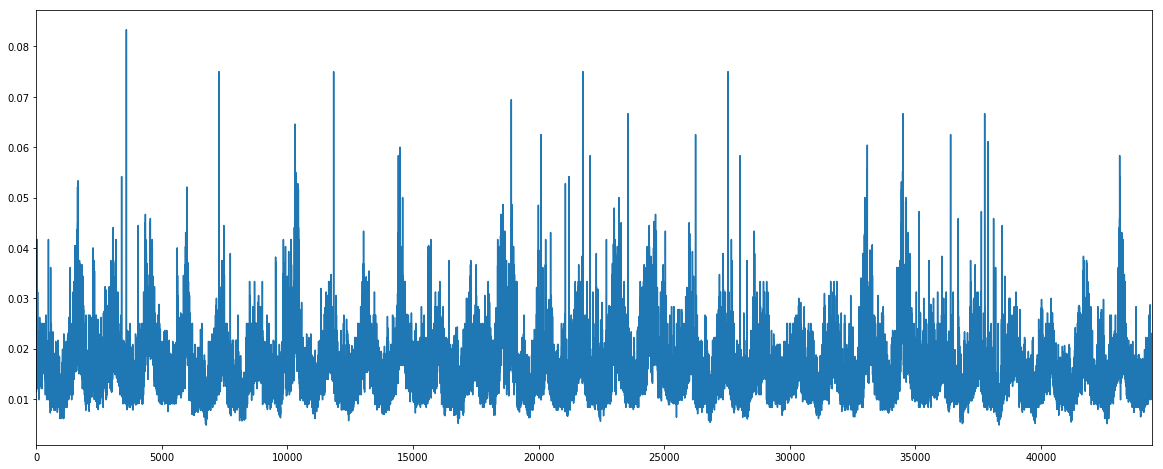

In [7]:
plt.figure(figsize=(20, 8))
df1['uber_price_per_second'].plot()

Convert data into array that can be broken up into training "batches" that we will feed into our RNN model. Note the shape of the arrays.

In [10]:
TS = np.array(df1['uber_price_per_second'])
num_periods = 444
f_horizon = 1 # forecast horizon, one period into the future

x_data = TS[:(len(TS)-(len(TS) % num_periods))]
x_batches = x_data.reshape(-1, 444, 1)

y_data = TS[1:(len(TS)-(len(TS) % num_periods)) + f_horizon]
y_batches = y_data.reshape(-1, 444, 1)
print(len(x_batches))
print(x_batches.shape)
print(x_batches[0:2])

print(y_batches[0:1])
print(y_batches.shape)

100
(100, 444, 1)
[[[ 0.02083333]
  [ 0.01145833]
  [ 0.01666667]
  [ 0.02083333]
  [ 0.01979167]
  [ 0.01527778]
  [ 0.01547619]
  [ 0.02083333]
  [ 0.01833333]
  [ 0.01388889]
  [ 0.01527778]
  [ 0.02083333]
  [ 0.01805556]
  [ 0.0125    ]
  [ 0.01833333]
  [ 0.01875   ]
  [ 0.02222222]
  [ 0.01770833]
  [ 0.01904762]
  [ 0.01597222]
  [ 0.01388889]
  [ 0.01309524]
  [ 0.01296296]
  [ 0.01527778]
  [ 0.04166667]
  [ 0.01354167]
  [ 0.02083333]
  [ 0.01833333]
  [ 0.01805556]
  [ 0.01458333]
  [ 0.01547619]
  [ 0.01944444]
  [ 0.01904762]
  [ 0.01547619]
  [ 0.01875   ]
  [ 0.02083333]
  [ 0.02261905]
  [ 0.01851852]
  [ 0.01904762]
  [ 0.02083333]
  [ 0.01515152]
  [ 0.02166667]
  [ 0.01354167]
  [ 0.01282051]
  [ 0.01666667]
  [ 0.01805556]
  [ 0.01785714]
  [ 0.01354167]
  [ 0.01875   ]
  [ 0.01527778]
  [ 0.02083333]
  [ 0.02083333]
  [ 0.03125   ]
  [ 0.01354167]
  [ 0.01875   ]
  [ 0.015     ]
  [ 0.01805556]
  [ 0.01785714]
  [ 0.0225    ]
  [ 0.01527778]
  [ 0.01875   ]
  [ 0.

We have 44434 total observations in our data. We want to make sure we have the same number of observations for each of our batch inputs.

What we see is our training data set is made up of 100 batches, containing about 444 observations. Each observation is a sequence of a single value.

The next step is to pull out our data.

In [11]:
def test_data(series, forecast, num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, 444, 1)
    testY = TS[-(num_periods):].reshape(-1, 444, 1)
    return testX, testY

X_test, Y_test = test_data(TS, f_horizon, num_periods)
print(X_test.shape)
print(X_test)

(1, 444, 1)
[[[ 0.00833333]
  [ 0.00980392]
  [ 0.01416667]
  [ 0.01041667]
  [ 0.0125    ]
  [ 0.009375  ]
  [ 0.00961538]
  [ 0.00735294]
  [ 0.01190476]
  [ 0.01083333]
  [ 0.00793651]
  [ 0.01      ]
  [ 0.00833333]
  [ 0.01287879]
  [ 0.00984848]
  [ 0.0125    ]
  [ 0.0125    ]
  [ 0.01041667]
  [ 0.01527778]
  [ 0.0122549 ]
  [ 0.01287879]
  [ 0.00793651]
  [ 0.0125    ]
  [ 0.01333333]
  [ 0.00952381]
  [ 0.01388889]
  [ 0.00892857]
  [ 0.01089744]
  [ 0.01166667]
  [ 0.00944444]
  [ 0.01180556]
  [ 0.00964912]
  [ 0.01309524]
  [ 0.00833333]
  [ 0.01212121]
  [ 0.01111111]
  [ 0.00833333]
  [ 0.00888889]
  [ 0.01785714]
  [ 0.01203704]
  [ 0.01041667]
  [ 0.01166667]
  [ 0.00833333]
  [ 0.00882353]
  [ 0.01574074]
  [ 0.01203704]
  [ 0.01153846]
  [ 0.01153846]
  [ 0.00984848]
  [ 0.00984848]
  [ 0.01481481]
  [ 0.00972222]
  [ 0.01011905]
  [ 0.00833333]
  [ 0.00877193]
  [ 0.01388889]
  [ 0.01190476]
  [ 0.01805556]
  [ 0.01      ]
  [ 0.01083333]
  [ 0.00952381]
  [ 0.009722

Now that we have our data, let’s create our TensorFlow graph that will do the computation.

In [13]:
tf.reset_default_graph() # we didn't have any previous graph objects running, but this would reset the graphs

num_periods = 444 # number of periods per vector we are using to predict one period ahead
inputs = 1        # number of vectors submitted
hidden = 2220     # number of neurons we will recursively work through, can be changed to improve accuracy
output = 1        # number of output vectors

X = tf.placeholder(tf.float32, [None, num_periods, inputs]) # create variable objects
y = tf.placeholder(tf.float32, [None, num_periods, output])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden) # create our RNN object
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32) # choose dynamic over static

learning_rate = 0.001 # small learning rate so we don't overshoot the minimum

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden]) # change the form into a tensor
stacked_outputs = tf.layers.dense(stacked_rnn_output, output) # specify the type of layer (dense)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output]) # shape of the results

loss = tf.reduce_sum(tf.square(outputs - y)) # define the cost function which evaluates the quality of our model
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) # gradient descent method
training_op = optimizer.minimize(loss) # train the result of the application of the cost_function

init = tf.global_variables_initializer() # initialize all the variables

We are specifying the number of periods we are using to predict. In this case, it is the number of sequences that we are feeding into the model as a single input. We specify our variable placeholders. We initialize a type of RNN cell to use (size 2220) and the type of activation function we want. ReLU stands for “Rectified Linear Unit” and is the default activation function, but it can be changed to Sigmoid, Hyberbolic Tangent (Tanh), and others, if desired.

We want our outputs to be in the same format as our inputs so we can compare our results using the loss function. In this case, we are using mean squared error (MSE), since this is a regression problem, in which our goal is to minimize the difference between the actual and the predicted. If we were dealing with a classification outcome, we might use cross-entropy. Now that we have this loss function defined, it is possible to define the training operation in TensorFlow that will optimize our network of input and outputs. To execute the optimization, we will use the Adam optimizer. Adam optimizer is a great general-purpose optimizer that performs our gradient descent via backpropagation through time. This allows faster convergence at the cost of more computation.

Now it is time to implement this model on our training data.

In [14]:
epochs = 1000 # number of iterations or training cycles, includes both the feedforward and backpropogation

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print(ep, '\tMSE:', mse)
            
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    print(y_pred)

0 	MSE: 3976.63
100 	MSE: 10.8089
200 	MSE: 2.86701
300 	MSE: 2.21418
400 	MSE: 1.92795
500 	MSE: 1.76136
600 	MSE: 1.66139
700 	MSE: 1.60248
800 	MSE: 1.56716
900 	MSE: 1.54297
[[[ 0.02069223]
  [-0.00251983]
  [ 0.01822642]
  [ 0.01424499]
  [ 0.00666769]
  [ 0.00612793]
  [ 0.01482818]
  [ 0.01423851]
  [ 0.01431239]
  [ 0.01987908]
  [ 0.01814396]
  [ 0.01678849]
  [ 0.01550416]
  [ 0.01644014]
  [ 0.01545153]
  [ 0.0159317 ]
  [ 0.01549242]
  [ 0.01636974]
  [ 0.01553682]
  [ 0.01596779]
  [ 0.01591701]
  [ 0.01571283]
  [ 0.01620278]
  [ 0.01585696]
  [ 0.01660812]
  [ 0.01597345]
  [ 0.01566516]
  [ 0.01552228]
  [ 0.01569853]
  [ 0.01559576]
  [ 0.0150387 ]
  [ 0.01568884]
  [ 0.01577053]
  [ 0.01649115]
  [ 0.01544759]
  [ 0.0165391 ]
  [ 0.015572  ]
  [ 0.01512588]
  [ 0.01609505]
  [ 0.01537136]
  [ 0.01638461]
  [ 0.01544093]
  [ 0.01589147]
  [ 0.01540211]
  [ 0.01642761]
  [ 0.01554752]
  [ 0.01596518]
  [ 0.01590762]
  [ 0.01570589]
  [ 0.01617823]
  [ 0.01586304]
  [ 0.

We specify the number of iterations/epochs that will cycle through our batches of training sequences. We create our graph object (tf.Session()) and initialize our data to be fed into the model as we cycle through the epochs. The abbreviated output shows the MSE after each 100 epochs. As our model feeds the data forward and backpropagation runs, it adjusts the weights applied to the inputs and runs another training epoch. Our MSE continues to improve (decrease). Finally, once the model is done, it takes the parameters and applies them to the test data to give us our predicted output for Y.

Let’s check our predicted versus actual. For our test data, we were focused on the last 444 periods of the entire 44434 periods.

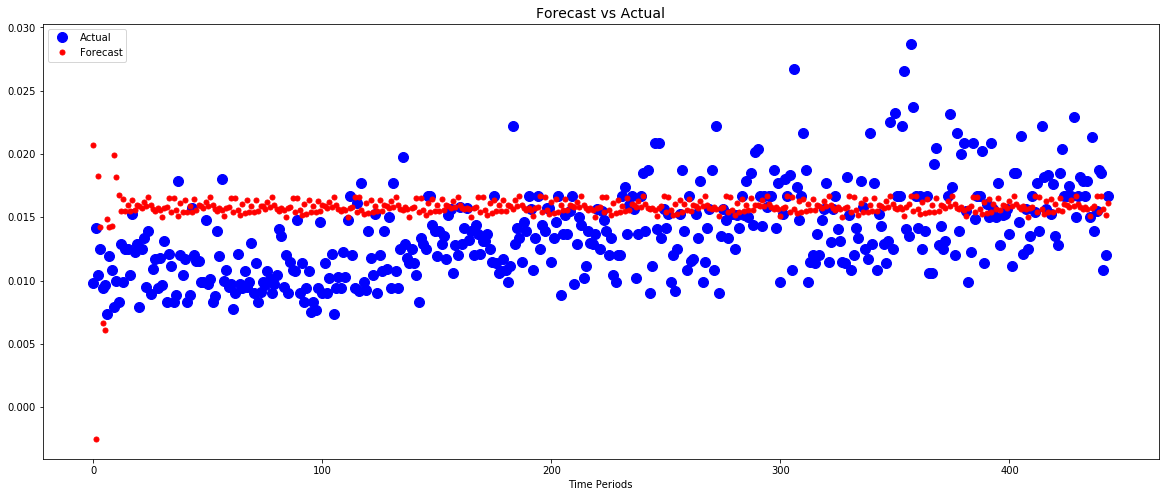

In [15]:
plt.figure(figsize=(20, 8))
plt.title('Forecast vs Actual', fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), 'bo', markersize=10, label='Actual')
plt.plot(pd.Series(np.ravel(y_pred)), 'r.', markersize=10, label='Forecast')
plt.legend(loc='upper left')
plt.xlabel('Time Periods')
plt.show()

It would appear there is some room for improvement. However, this can be done by changing the number of hidden neurons and/or increasing the number of epochs. Optimizing our model is a process of trial and error, but we have a great start. This is random data, so we were expecting great results, but perhaps applying this model to a real-time series would give the ARIMA models some quality competition. RNNs (and Deep Learning in general) are expanding the options available to data scientists to solve interesting problems.